In [2]:
!pip install rasterio

     |████████████████████████████████| 19.3 MB 1.2 MB/s 


In [3]:
import os
import copy
from itertools import product

import cv2
import rasterio
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
images_path = "/content/drive/MyDrive/Projects/3rd-Year-Project/NDWI/Satellite Images/"

images_path_dictionary = {}

for path in os.listdir(images_path):
    for image in os.listdir(images_path + path):
        images_name_array = []
        if image.endswith("_B3.TIF"):
            image_path = os.path.join(images_path, path, image)
            images_name_array.append(image_path)
            images_name_array.append(image_path.replace("_B3.TIF", "_B5.TIF"))
            images_name_array.append(image_path.replace("_B3.TIF", "_B6.TIF"))
            images_name_array.append(image_path.replace("_B3.TIF", "_B7.TIF"))

            images_path_dictionary[image.replace("_B3.TIF", "")] = images_name_array

In [5]:
ndwi_dictionary = {}

for i in images_path_dictionary.keys():
    band3 = rasterio.open(images_path_dictionary[i][0])
    band5 = rasterio.open(images_path_dictionary[i][1])
    band6 = rasterio.open(images_path_dictionary[i][2])
    band7 = rasterio.open(images_path_dictionary[i][3])

    green = band3.read(1).astype("float32")
    nir = band5.read(1).astype("float32")
    swir1 = band6.read(1).astype("float32")
    swir2 = band7.read(1).astype("float32")

    ndwi_nir = np.where(
        (green+nir) == 0.,
        0,
        (green-nir)/(green+nir)
    )

    ndwi_swir1 = np.where(
        (green+swir1) == 0.,
        0,
        (green-swir1)/(green+swir1)
    )

    ndwi_swir2 = np.where(
        (green+swir2) == 0.,
        0,
        (green-swir2)/(green+swir2)
    )

    ndwi_nir_copy = copy.copy(ndwi_nir)
    ndwi_nir_copy[ndwi_nir > 0] = -100
    ndwi_nir_copy[ndwi_nir <= 0] = 0

    ndwi_swir1_copy = copy.copy(ndwi_swir1)
    ndwi_swir1_copy[ndwi_swir1 > 0] = -100
    ndwi_swir1_copy[ndwi_swir1 <= 0] = 0

    ndwi_swir2_copy = copy.copy(ndwi_swir2)
    ndwi_swir2_copy[ndwi_swir2 > 0] = -100
    ndwi_swir2_copy[ndwi_swir2 <= 0] = 0

    ndwi_dictionary[i] = [ndwi_nir_copy, ndwi_swir1_copy, ndwi_swir2_copy]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


In [6]:
processed_images_path = "/content/drive/MyDrive/Projects/3rd-Year-Project/NDWI/Processed Images/"

for m in ndwi_dictionary.keys():
    for n in range(3):
        img = cv2.threshold(
            np.uint8(ndwi_dictionary[m][n]), 0, 255, cv2.THRESH_BINARY)[1]

        nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(
            img)
        sizes = stats[1:, -1]
        nb_components = nb_components - 1

        min_size = 100 * (n+1)

        ndwi_components = np.zeros((output.shape))
        for i in range(0, nb_components):
            if sizes[i] >= min_size:
                ndwi_components[output == i + 1] = -100

        if n == 0:
            img_save_path = os.path.join(
                processed_images_path, (m + "_nir" + ".png"))
        elif n == 1:
            img_save_path = os.path.join(
                processed_images_path, (m + "_swir1" + ".png"))
        elif n == 2:
            img_save_path = os.path.join(
                processed_images_path, (m + "_swir2" + ".png"))

        plt.imsave(img_save_path, ndwi_components, format="png")

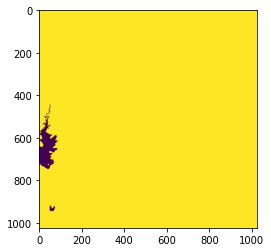

In [ ]:
dh = 1024
dw = 1024

for image in os.listdir(processed_images_path):
    name, ext = os.path.splitext(image)
    img = Image.open(os.path.join(processed_images_path, image))
    w, h = img.size

    grid = product(range(0, h-(h % dh), dh), range(0, w-(w % dw), dw))
    for i, j in grid:
        if j+dw <= w:
            box = (j, i, j+dw, i+dh)
            out = os.path.join(
                "/content/drive/MyDrive/Projects/3rd-Year-Project/NDWI/Cropped/", f'{name}{j}x{i}_{j+dw}x{i+dh}{ext}')
            cropped_img = img.crop(box)
            np_cropped_img = np.asarray(cropped_img)
            print()
            if np.all(np_cropped_img == np_cropped_img[0]):
                continue
            else:
                cropped_img.save(out)